In [20]:
using MLDatasets
using MLDatasets.MNIST: convert2image
train_x, train_y = MNIST.traindata()
test_x,  test_y  = MNIST.testdata();

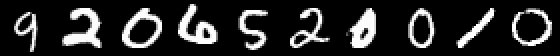

In [21]:
using Images, Random, StatsBase
Random.seed!(1234)
n_samples = 10
samples = train_x[:,:,sample(1:end, n_samples, replace=false)]
mosaicview([convert2image(samples[:,:,i]) for i ∈ 1:n_samples]...,ncol=n_samples)

## Classifier

In [3]:
output_dim = 10
input_dim = prod(size(train_x[:,:,1]))
hidden_dim = 32

32

In [4]:
using Flux
using Flux: onehotbatch, onecold
y = Flux.unstack(Flux.onehotbatch(train_y, 0:9),2)
x = Flux.unstack(Flux.flatten(train_x), 2)
nn = Chain(
    Dense(input_dim, hidden_dim, relu),
    Dense(hidden_dim, output_dim)
)
loss(x, y) = Flux.Losses.logitcrossentropy(nn(x), y)
data = zip(x,y);

In [5]:
using Flux.Optimise: update!, ADAM
using Statistics
opt = ADAM()
epochs = 10
avg_loss(data) = mean(map(d -> loss(d[1],d[2]), data))
accuracy(data) = mean(map(d -> onecold(softmax(nn(d[1])), 0:9) .== onecold(d[2], 0:9), data))

if false
  for epoch = 1:epochs
    for d in data
      gs = gradient(params(nn)) do
        l = loss(d...)
      end
      update!(opt, params(nn), gs)
    end
    @info "Epoch " * string(epoch)
    @show accuracy(data)
  end
end

using BSON: @save
@save "data/MNIST.bson" nn

In [6]:
test_data = zip(Flux.unstack(Flux.flatten(test_x), 2),Flux.unstack(Flux.onehotbatch(test_y, 0:9),2))
accuracy(test_data)

0.1013

## Recourse

In [7]:
using AlgorithmicRecourse, AlgorithmicRecourse.Models
import AlgorithmicRecourse.Models: logits, probs # import functions in order to extend

# Step 1)
struct NeuralNetwork <: Models.FittedModel
    nn::Any
end

# Step 2)
logits(𝑴::NeuralNetwork, X::AbstractArray) = 𝑴.nn(X)
probs(𝑴::NeuralNetwork, X::AbstractArray)= softmax(logits(𝑴, X))
𝑴 = NeuralNetwork(nn);

In [32]:
# Randomly selected factual:
Random.seed!(1234);
x̅ = x[rand(1:length(x))]
y̅ = findall(collect(0:9).==onecold(probs(𝑴, x̅),0:9))[1]
target = rand(filter!(x -> x ≠ y̅, collect(1:10)))
γ = 0.75
# Define Generator:
generator = GenericGenerator(0.1,0.1,1e-5,:logitcrossentropy,nothing)
# Generate recourse:
recourse = generate_recourse(generator, x̅, 𝑴, target, γ); # generate recourse

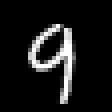

In [33]:
convert2image(reshape(recourse.x̅,Int(sqrt(input_dim)),Int(sqrt(input_dim))))

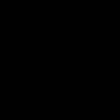

In [38]:
convert2image(reshape(recourse.x̲,Int(sqrt(input_dim)),Int(sqrt(input_dim))))

In [43]:
reshape(recourse.x̅,Int(sqrt(input_dim)),Int(sqrt(input_dim)))

28×28 Array{N0f8,2} with eltype N0f8:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0